In [1]:
#load these before doing anything else
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Title: Clinical Determinants of Heart Disease

Introduction:
We are using the Heart Disease Dataset from Kaggle (link: https://www.kaggle.com/datasets/ineubytes/heart-disease-dataset)
The data set contains 14 columns, which include information of the patients’ age, sex, chest pain, cholesterol levels, and other clinical factors. The last column, target, indicated by values 0, and 1, represents whether the patient has heart defects (0 = does not have heart disease; 1 = have heart disease). The dataset seems to already be in a tidy format.

Research question: We are aiming to predict whether an individual has heart disease (ie. the target value)  using 4 predictors, age, serum cholesterol in mg/dl(chol), maximum heart rate achieved(thalach), resting blood pressure (in mm Hg on admission to the hospital)(trestbps). 

We chose these four predicators because they seem clinically related to the risk of heart disease. Clinical data identifies cholesterol at and above 240 mg/dl to be high. Systolic blood pressure over 140 mmHg and/or diastolic blood pressure over 90 mmHg are considered high blood pressure. It is considered critical if one’s maximum heart rate exceed their age subtracted by 200. These factors have all be proven to increase the risk of heart disease in patients. We are analyzing our data with the help of these clinical standards. 


Preliminary exploratory data analysis:

In [2]:
#reading in our data set:

set.seed(123)
heart_data<-read_csv("https://raw.githubusercontent.com/jewelw11/dsci-100-project/main/heart%20(4).csv")

heart_data_1<- heart_data|>
select(age, trestbps, chol, thalach, target) |>
mutate(target=as_factor(target))



Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Splitting it into training and test sets

In [3]:
heart_split <- initial_split(heart_data_1, prop = 0.75, strata = target)
heart_training<-training(heart_split)
heart_testing<- testing(heart_split)
heart_training

age,trestbps,chol,thalach,target
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
53,140,203,155,0
70,145,174,125,0
61,148,203,161,0
⋮,⋮,⋮,⋮,⋮
47,112,204,143,1
59,140,221,164,1
50,110,254,159,1


Exploratory analyses

Section: summarizing the data into table(s)

Using the Cholesterol (chol column)

 target: 0=not diagnosed with heart disease
         1= diagnosed with heart disease

reminder: High cholesterol is clinically diagnosed when a patient's cholesterol is equal to or over 240 mg/dl

In [4]:
high_chol <- heart_training |>
select(chol, target)|>
filter(chol >= 240)|>
group_by(target)|>
summarize(count=n())

high_chol


target,count
<fct>,<int>
0,214
1,187


Section: summarizing the data into table(s), part 2
Maximum heart rate (thalach column)

In [6]:
normal_max_heart_rate <- heart_training|>
mutate(normal_thalach = 220 - age)

high_heart_rate <- normal_max_heart_rate|>
mutate(diff_thalach= normal_thalach - thalach)|>
mutate(diff_thalach_2 = ifelse(diff_thalach >= 0, "no", "yes"))
high_heart_rate



age,trestbps,chol,thalach,target,normal_thalach,diff_thalach,diff_thalach_2
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>
53,140,203,155,0,167,12,no
70,145,174,125,0,150,25,no
61,148,203,161,0,159,-2,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
47,112,204,143,1,173,30,no
59,140,221,164,1,161,-3,yes
50,110,254,159,1,170,11,no


Normal max heart rate is calculated using a fixed equation: 220-age
comparing calculated (normal) max heart rate with the measured heart rate(thalach column)
we can quantify whether heart rate is critically high by comparing these two rows.
if the difference between the 2 rows is a negative value then max heart rate is considered high and potentially dangerous.

Section: Visualization for Maximum Heart Rate (thalach column)

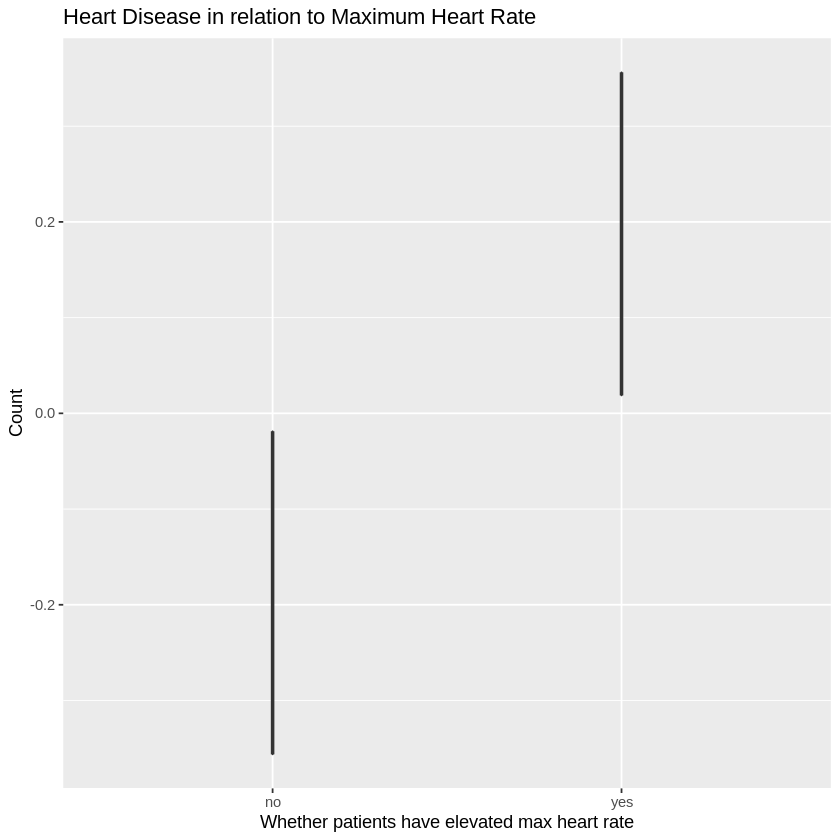

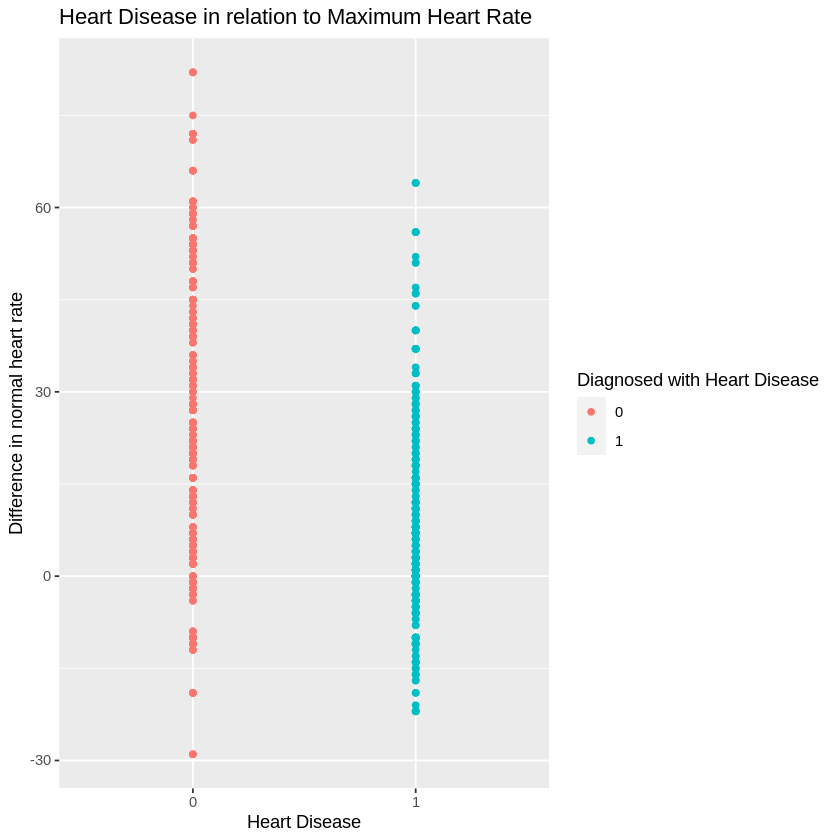

In [7]:

high_heart_plot <- high_heart_rate |>
ggplot(aes(x = diff_thalach_2)) + 
geom_boxplot() + 
labs(x = "Whether patients have elevated max heart rate", y = "Count", fill= "Diagnosed with Heart Disease")+
ggtitle("Heart Disease in relation to Maximum Heart Rate") 
high_heart_plot

#second plot (same data):
plot<- high_heart_rate|>
ggplot(aes(x= target, y= diff_thalach, color= target))+
geom_point()+
labs(x= "Heart Disease", y= "Difference in normal heart rate", colour= "Diagnosed with Heart Disease" )+
ggtitle("Heart Disease in relation to Maximum Heart Rate")
plot


Both graphs show that patients with a negative difference between their hypothesized "normal" max heart rate and their actual recorded max heart rate (ie, recorded max heart rate is over the normal limit), tend to be diagnosed with heart disease (1). In the first graph in particular, a greater proportion of people with a max heart rate over the normal limit have been diagnosed with heart disease, as compared to the patients without elevated max heart rates.

age,trestbps,chol,thalach,target
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
53,140,203,155,0
70,145,174,125,0
61,148,203,161,0
⋮,⋮,⋮,⋮,⋮
47,112,204,143,1
59,140,221,164,1
50,110,254,159,1


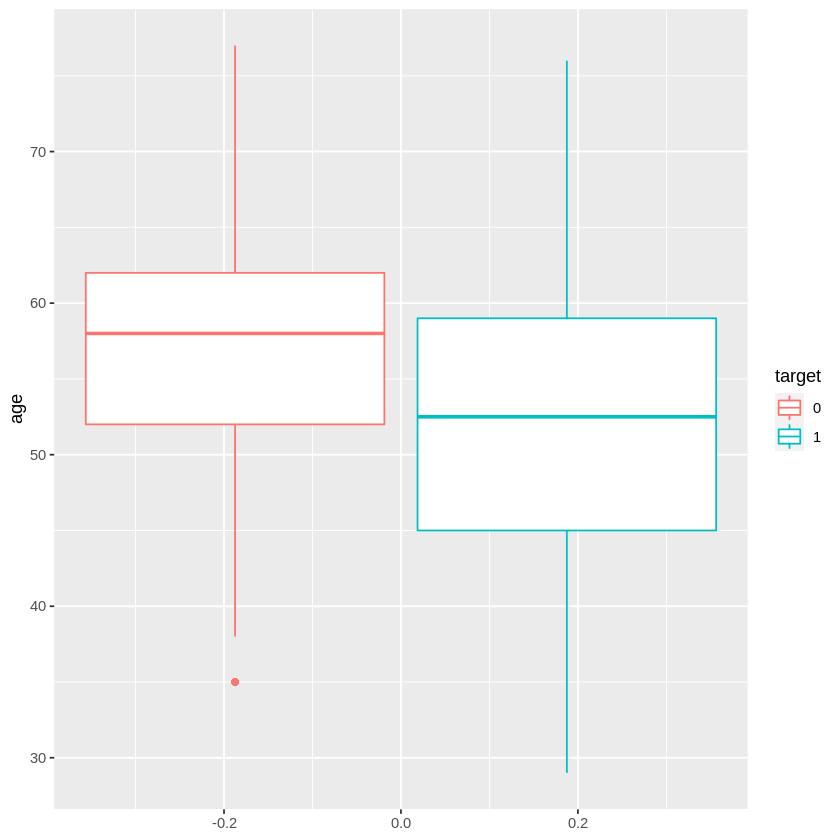

In [8]:
box_plot_age<- heart_training|>
ggplot(aes(x=age, colour=target))+
geom_boxplot()+
xlab("age")+
coord_flip()


box_plot_age
heart_training


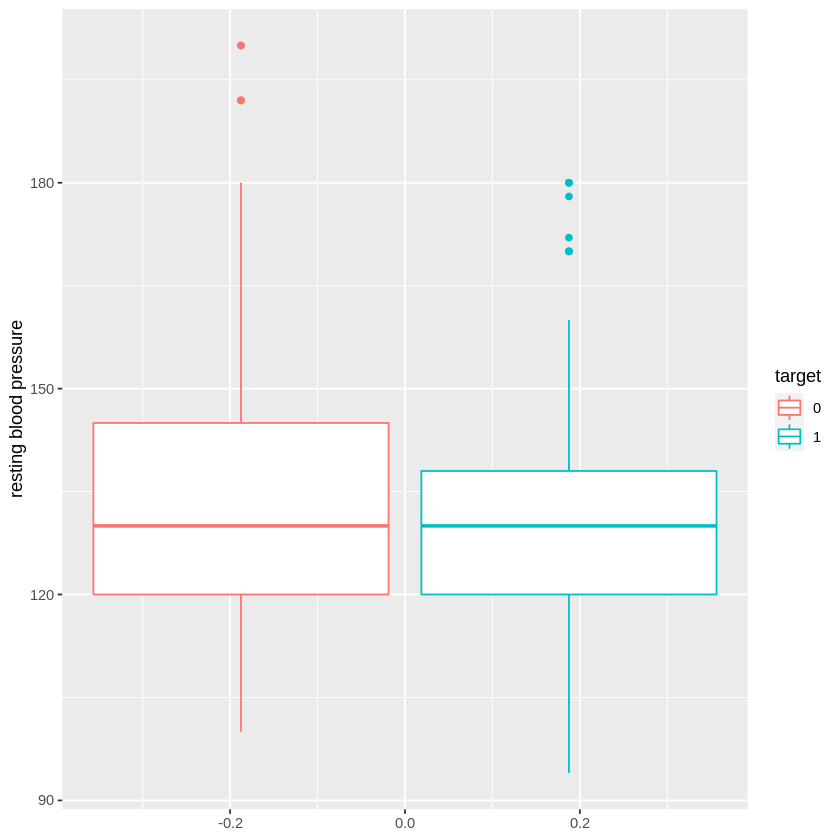

In [9]:
box_plot_age<- heart_training|>
ggplot(aes(x=trestbps, colour=target))+
geom_boxplot()+
xlab("resting blood pressure")+
coord_flip()
box_plot_age

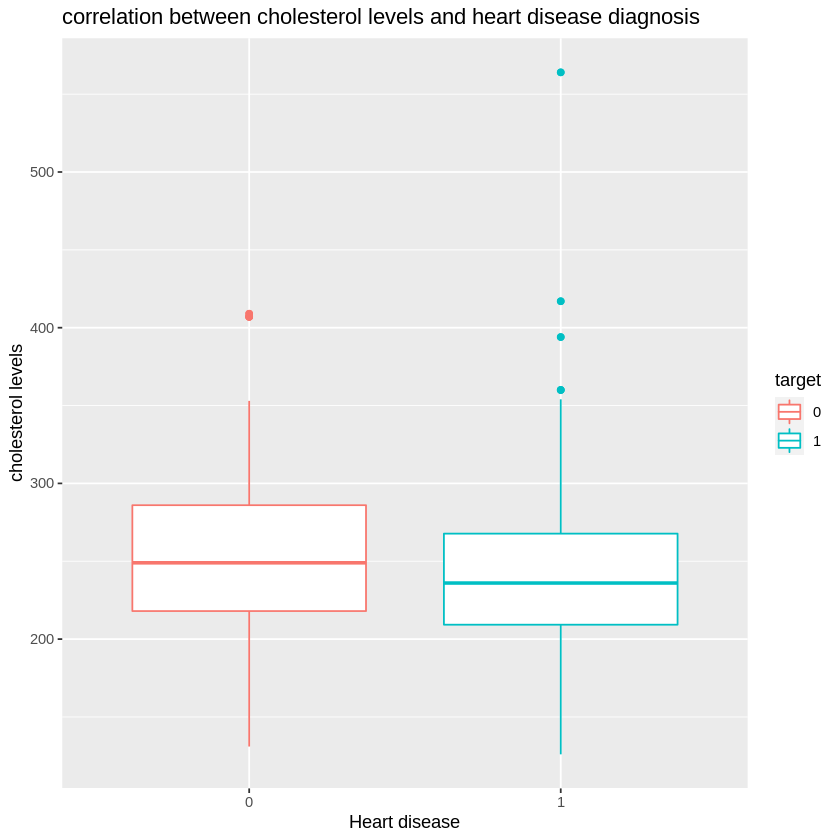

In [10]:
box_plot_age<- heart_training|>
ggplot(aes(x=chol, y=target,colour=target))+
geom_boxplot()+
labs(x="cholesterol levels", y="Heart disease")
box_plot_age+
coord_flip()+
ggtitle("correlation between cholesterol levels and heart disease diagnosis")

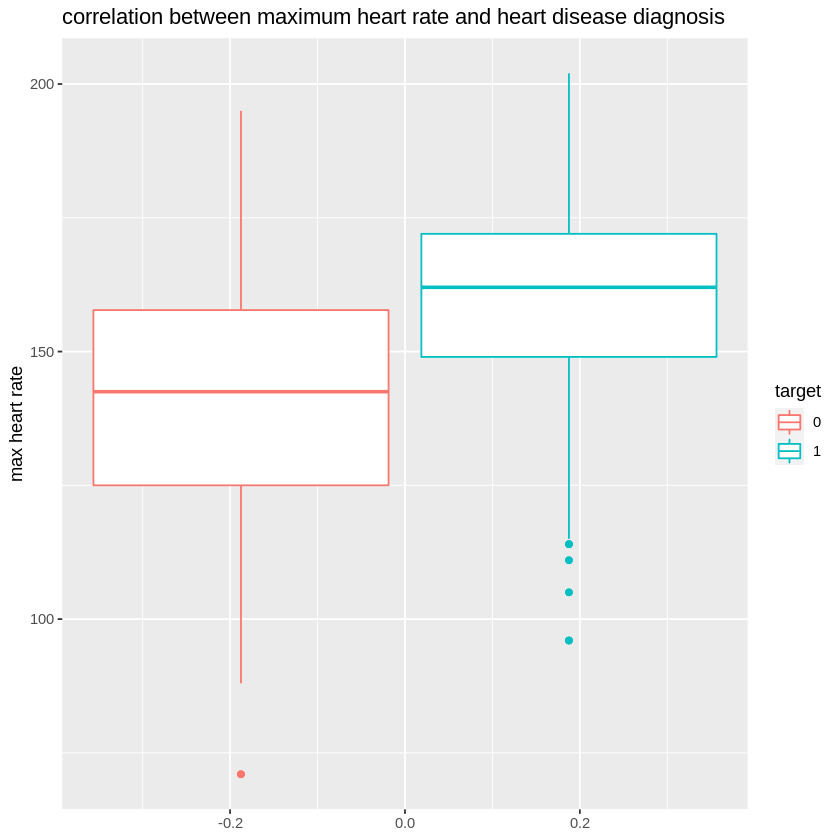

In [11]:
box_plot_age<- heart_training|>
ggplot(aes(x=thalach, colour=target))+
geom_boxplot()+
xlab("max heart rate")
box_plot_age+
coord_flip()+
ggtitle("correlation between maximum heart rate and heart disease diagnosis")

Part 2: Classification

In [14]:
set.seed(123)
heart_training_recipe<- recipe(target~ age, thalach, data= heart_training)|>
step_center(all_predictors())|>
step_scale(all_predictors())


heart_spec<- nearest_neighbor(weight_func = "rectangular", neighbors= tune()) |>
set_engine("kknn") |>
set_mode ("classification")


heart_vfold <- vfold_cv(heart_training, v = 5, strata = target)


heart_workflow <- workflow() |>
       add_recipe(heart_training_recipe) |>
       add_model(heart_spec) |>
       fit(data = heart_training)

gridvals <- tibble(neighbors = seq(from =1, to = 100, by =5))

heart_results <- heart_workflow |>
       tune_grid(resamples = heart_vfold, grid = gridvals) |>
       collect_metrics()

heart_results

accuracy <-  heart_results |>  
filter(.metric == "accuracy")





Warning message:
“tune samples were requested but there were 768 rows in the data. 763 will be used.”


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5260082,5,0.005412502,Preprocessor1_Model01
1,roc_auc,binary,0.5370909,5,0.005326038,Preprocessor1_Model01
6,accuracy,binary,0.5155502,5,0.007877259,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
91,roc_auc,binary,0.6770576,5,0.01905879,Preprocessor1_Model19
96,accuracy,binary,0.6432502,5,0.01412830,Preprocessor1_Model20
96,roc_auc,binary,0.6758013,5,0.01747643,Preprocessor1_Model20


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5260082,5,0.005412502,Preprocessor1_Model01
6,accuracy,binary,0.5155502,5,0.007877259,Preprocessor1_Model02
11,accuracy,binary,0.5806904,5,0.009474989,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,accuracy,binary,0.6406186,5,0.01473107,Preprocessor1_Model18
91,accuracy,binary,0.6393541,5,0.01379329,Preprocessor1_Model19
96,accuracy,binary,0.6432502,5,0.01412830,Preprocessor1_Model20


[1] 46

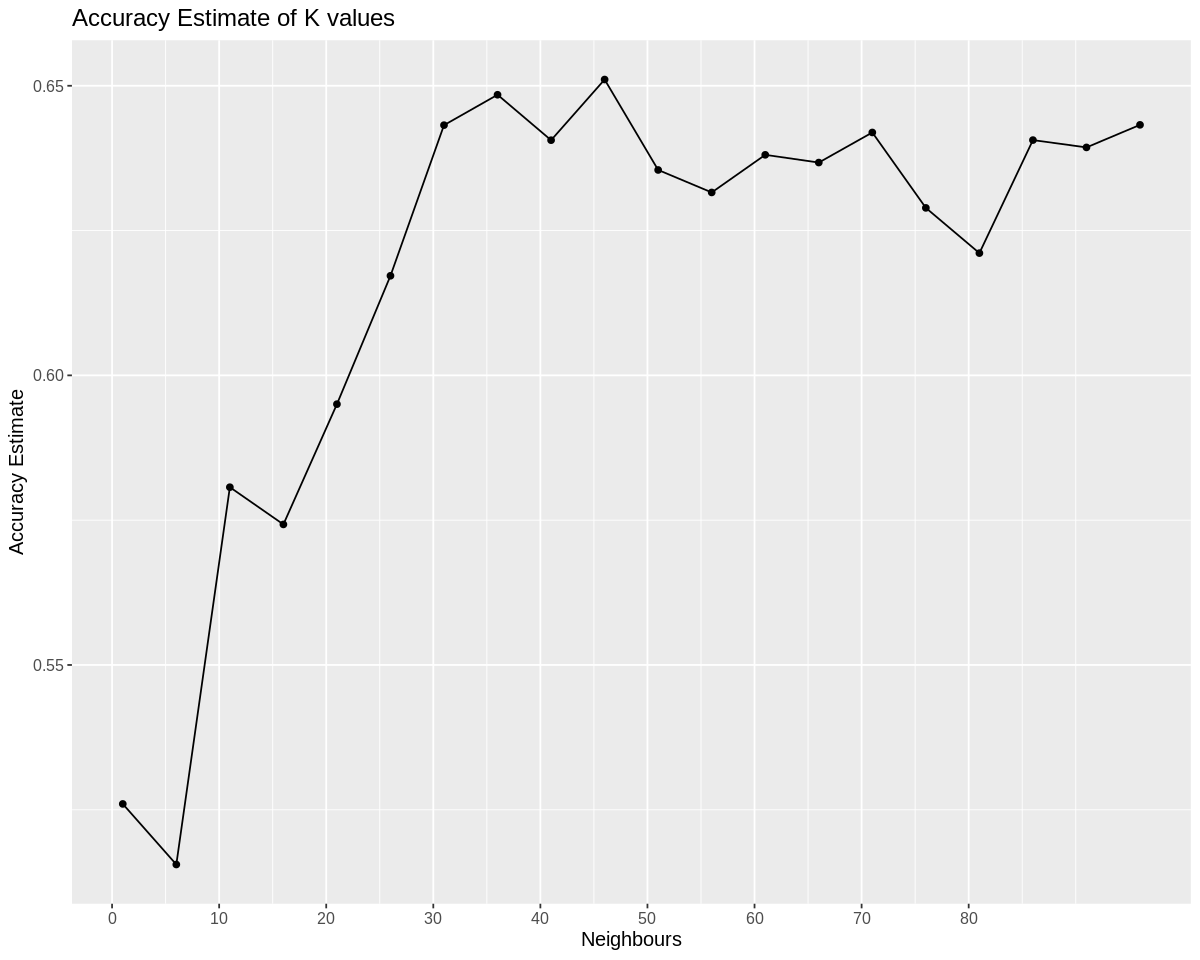

In [41]:
set.seed(123)
accuracy


options(repr.plot.width = 10, repr.plot.height = 8)

cross_val_plot <- ggplot(accuracy, aes(x = neighbors, y = mean)) +
geom_point () +
geom_line () +
labs(x = "Neighbours", y = "Accuracy Estimate") +
ggtitle("Accuracy Estimate of K values") +
theme(text=element_text(size=12))+
       scale_x_continuous(breaks = seq(0, 80, by = 10))



cross_val_plot

heart_max <- accuracy |>
filter(mean == max(mean))|>
pull(neighbors)

heart_max


In [44]:

heart_spec<- nearest_neighbor(weight_func = "rectangular", neighbors=6) |>
set_engine("kknn") |>
set_mode ("classification")



knn_fit<- workflow()|>
add_recipe(heart_training_recipe)|>
add_model(heart_spec)|>
fit(data=heart_training)


heart_test_predictions<- predict(knn_fit, heart_testing)|>
bind_cols(heart_testing)


Both graphs show that patients with a negative difference between their hypothesized "normal" max heart rate and their actual recorded max heart rate (ie, recorded max heart rate is over the normal limit), tend to be diagnosed with heart disease (1). In the first graph in particular, a greater proportion of people with a max heart rate over the normal limit have been diagnosed with heart disease, as compared to the patients without elevated max heart rates

Methods:
We will select for the age, trestbps (resting blood pressure), chol (cholesterol), thalach (maximum heart rate), and target (diagnosed heart disease or not) columns. We will do a K-nearest neighbours classification on the heart disease dataset, using the target column as our class label, and the other 4 columns as our predictors. We will test for which K to use to generate the highest accuracy. Then we will show the results of our prediction in a graph or a few graphs linked together. We believe that age, resting heart rate, cholesterol, and maximum heart rate are important factors in determining and predicting heart disease in an individual.
We will create multiple scatter plots for example, plotting target (x-axis) and age (y-axis) to determine the positive or negative trends.


Expected outcomes and significance:
We expect that factors such as increased age, blood pressure, cholesterol and heart rates would increase the chances of heart disease, meaning that you could be more susceptible to heart disease. 
This would be a very helpful way to make quick predictions of whether certain factors increase the chances of heart disease. Of course, these predictions are not professional diagnoses; however, they can still be good baseline tests for medical professionals to use on patients.
We can wonder what other factors and combinations of factors can increase the chances of heart disease. 
